## Example 10.1: Mountain Car Task

Consider the task of driving an underpowered car up a steep mountain road, as shown in the upper-left diagram of Figure 10.1.

The difficulty is that gravity is stronger than the car’s engine, so even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then, by applying full throttle, the car can build up enough inertia to carry it up the steep slope—even though it is slowing down the whole way.

This is a simple example of a continuous control task where things have to get worse (farther from the goal) before they can get better. Many control methodologies have great difficulties with tasks of this kind unless explicitly aided by a human designer.

---

### Rewards and Actions

* **Reward**: $-1$ on all time steps until the car reaches the goal position at the top of the mountain, which ends the episode.
* **Actions**:

  * Full throttle forward ($+1$)
  * Full throttle reverse ($-1$)
  * Zero throttle ($0$)

---

### Dynamics

The car moves according to simplified physics. Let:

* $x_t$ = position
* $\dot{x}_t$ = velocity
* $A_t$ = action at time $t$

The updates are:

$$
x_{t+1} = \text{bound} \left[ x_t + \dot{x}_{t+1} \right]
$$

$$
\dot{x}_{t+1} = \text{bound} \left[ \dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t) \right]
$$

Where:

* Position bounds: $-1.2 \leq x_{t+1} \leq 0.5$
* Velocity bounds: $-0.07 \leq \dot{x}_{t+1} \leq 0.07$

Additional rules:

* If $x_{t+1}$ reaches the left bound, reset $\dot{x}_{t+1} = 0$.
* If $x_{t+1}$ reaches the right bound, the goal is reached and the episode terminates.

---

### Episode Initialization

* Start position $x_t \in [-0.6, -0.4)$
* Start velocity $\dot{x}_t = 0$

---

### Feature Representation

To convert the two continuous state variables into binary features, **tile coding** was used (as in Figure 9.9):

* **Tilings**: 8
* Each tile covers $\frac{1}{8}$ of the bounded distance in each dimension.
* Asymmetrical offsets as described in Section 9.5.4.

Let $\mathbf{x}(s,a)$ be the binary feature vector for state–action pair $(s,a)$. The action-value function is approximated as:

$$
\hat{q}(s, a, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s, a) = \sum_{i=1}^{d} w_i \cdot x_i(s, a) \tag{10.3}
$$

---

### Learning Behavior

Figure 10.1 shows the negative of the value function (the **cost-to-go function**) learned in one run.

* **Initial action values**: all set to $0$, which is **optimistic** (true values are negative), causing extensive exploration even with $\epsilon = 0$.
* Early in learning (e.g., Step 428), the agent has not completed an episode but oscillates back and forth in the valley, following circular trajectories in state space.
* Frequently visited states are valued worse than unexplored states because rewards so far have been worse than expected.
* This drives the agent to continually explore new states until a solution is found.

![example 10.1](assets/10.1_figure_10.2.png)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from autograd import grad

ACTIONS = ['forward', 'backward', 'stay']
X_BOUNDS = (-1.2, .6)
VELOCITY_BOUNDS = (-.07, .07)
TERMINAL_X = 0.6
TERMINAL_REWARD = 0
NON_TERMINAL_REWARD = -1
START_X_BOUNDS = (-.6, -0.4)
START_VELOCITY = 0
NUM_TILES = 64
TILING_ROWS_AND_COLS = (8, 8)
TILING_OFFSETS = [
    (0.0, 0.0),
    (1/8, 3/8),
    (2/8, 6/8),
    (3/8, 1/8),
    (4/8, 4/8),
    (5/8, 7/8),
    (6/8, 2/8),
    (7/8, 5/8),
]
NUM_FEATURES = len(TILING_OFFSETS) * NUM_TILES
NUM_ACTION_FEATURES = NUM_FEATURES * len(ACTIONS)

# all inputs are tuples
def get_tile_vector(
    state,
    space_x_range=X_BOUNDS,
    space_y_range=VELOCITY_BOUNDS,
    tile_rows_and_cols=TILING_ROWS_AND_COLS,
    offset=TILING_OFFSETS[0]
):
    rows, cols = tile_rows_and_cols
    num_tiles = rows * cols
    tile_width = (space_x_range[1] - space_x_range[0]) / cols
    tile_height = (space_y_range[1] - space_y_range[0]) / rows

    # offset is fraction of a tile in each dimension (e.g., 0.5 = half-tile shift)
    offset_x_world = offset[0] * tile_width
    offset_y_world = offset[1] * tile_height

    x, y = state
    x_min, _ = space_x_range
    y_min, _ = space_y_range

    col = math.floor((x - x_min + offset_x_world) / tile_width)
    row = math.floor((y - y_min + offset_y_world) / tile_height)

    col = max(0, min(cols - 1, col))
    row = max(0, min(rows - 1, row))

    tile_vector = np.zeros(num_tiles)
    tile_vector[row * cols + col] = 1
    return tile_vector
  
def get_feature_vector(
    state, 
    space_x_range=X_BOUNDS, 
    space_y_range=VELOCITY_BOUNDS, 
    tile_rows_and_cols=TILING_ROWS_AND_COLS, 
    offsets=TILING_OFFSETS
):
    feature_vectors = []
    for i, offset in enumerate(offsets):
        feature_vectors.append(get_tile_vector(state, space_x_range, space_y_range, tile_rows_and_cols, offset))
    return np.concatenate(feature_vectors)

def get_action_feature_vector(state, action):
    state_feature_vector = get_feature_vector(state, X_BOUNDS, VELOCITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    action_feature_vector = np.zeros(NUM_ACTION_FEATURES)
    action_index = ACTIONS.index(action)
    start = action_index * NUM_FEATURES
    end = start + NUM_FEATURES
    action_feature_vector[start:end] = state_feature_vector
    return action_feature_vector

def position_update(x_pos, velocity):
    return max(min(x_pos + velocity, X_BOUNDS[1]), X_BOUNDS[0])

def velocity_update(x_pos, velocity, action ):
    if action == 'forward':
        thrust = 1
    elif action == 'backward':
        thrust = -1
    else:
        thrust = 0
    return max(min(velocity + .001 * thrust - .0025 * math.cos(3 * x_pos), VELOCITY_BOUNDS[1]), VELOCITY_BOUNDS[0])

def update_state(state, action):
    new_velocity = velocity_update(state[0], state[1], action)
    new_x_pos = position_update(state[0], new_velocity)
    if new_x_pos == X_BOUNDS[0]:
        new_velocity = 0
    return (new_x_pos, new_velocity)

def get_reward(state):
    if state[0] >= TERMINAL_X:
        return TERMINAL_REWARD
    else:
        return NON_TERMINAL_REWARD
    
def get_next_state_and_reward(state, action):
    new_state = update_state(state, action)
    reward = get_reward(new_state)
    return new_state, reward

def get_start_state():
    return (np.random.uniform(START_X_BOUNDS[0], START_X_BOUNDS[1]), START_VELOCITY)
    
def get_action_value(state, action, w):
    feature_vector = get_action_feature_vector(state, action)
    return np.dot(w, feature_vector)

def get_action_values(state, w):
    state_feature_vector = get_feature_vector(state, X_BOUNDS, VELOCITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    values = []
    for i in range(len(ACTIONS)):
        start = i * NUM_FEATURES
        end = start + NUM_FEATURES
        w_slice = w[start:end]
        values.append(np.dot(w_slice, state_feature_vector))
    return values

def get_next_action(w, state, epsilon):
    action_values = get_action_values(state, w)
    best_action = ACTIONS[np.argmax(action_values)]
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        return best_action

def get_best_action(w, state):
    action_values = get_action_values(state, w)
    return ACTIONS[np.argmax(action_values)]

def generate_episode(w, epsilon):
    episode = []
    state = get_start_state()
    action = get_next_action(w, state, epsilon)
    while state[0] < TERMINAL_X:
        next_state, reward = get_next_state_and_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        action = get_next_action(w, state, epsilon)
    episode.append((state, None, 0))
    return episode

def train_semi_gradient_sarsa(alpha, epsilon, gamma, num_episodes):
    w = np.zeros(NUM_ACTION_FEATURES)
    steps_per_episode = []
    for episode in range(num_episodes):
        state = get_start_state()
        action = get_next_action(w, state, epsilon)
        steps = 0
        while True:
            next_state, reward = get_next_state_and_reward(state, action)
            steps += 1
            if next_state[0] >= TERMINAL_X:
                delta = reward - get_action_value(state, action, w)
                w += alpha * delta * get_action_feature_vector(state, action)
                steps_per_episode.append(steps)
                break
            next_action = get_next_action(w, next_state, epsilon)
            delta = reward + gamma * get_action_value(next_state, next_action, w) - get_action_value(state, action, w)
            w += alpha * delta * get_action_feature_vector(state, action)
            state = next_state
            action = next_action
    return w, steps_per_episode

w, steps_per_episode = train_semi_gradient_sarsa(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500)

print(w)
print(steps_per_episode)

episode = generate_episode(w, epsilon=0)
print(len(episode))

[-5.5827658  -7.24739154 -9.22739107 ... -2.86738203 -2.09659799
 -1.3505666 ]
[1487, 1002, 748, 683, 523, 315, 369, 372, 489, 425, 295, 268, 288, 199, 202, 272, 248, 232, 232, 192, 157, 239, 242, 190, 156, 204, 185, 209, 199, 205, 195, 193, 153, 151, 194, 180, 231, 159, 206, 116, 161, 217, 164, 147, 146, 121, 152, 201, 149, 158, 161, 161, 161, 158, 198, 113, 163, 160, 155, 155, 125, 158, 151, 152, 126, 131, 118, 126, 116, 115, 115, 113, 124, 199, 130, 176, 162, 248, 118, 142, 154, 137, 150, 162, 158, 165, 155, 153, 118, 153, 148, 121, 118, 118, 111, 151, 151, 155, 146, 158, 115, 161, 187, 157, 151, 160, 124, 163, 143, 113, 174, 122, 151, 118, 151, 131, 120, 147, 156, 154, 152, 149, 150, 147, 115, 159, 149, 170, 157, 124, 159, 159, 123, 119, 151, 158, 158, 168, 156, 149, 158, 145, 150, 121, 153, 120, 128, 113, 147, 201, 151, 150, 150, 155, 129, 162, 155, 155, 154, 149, 149, 120, 142, 151, 178, 154, 184, 156, 150, 130, 113, 155, 123, 120, 118, 148, 146, 153, 154, 145, 130, 152, 124, 155

In [2]:
def get_avg_steps_per_episode(alpha, epsilon, gamma, num_episodes):
    steps_per_episodes = []
    for i in range(100):
        w, steps_per_episode = train_semi_gradient_sarsa(alpha=alpha, epsilon=epsilon, gamma=gamma, num_episodes=num_episodes)
        steps_per_episodes.append(steps_per_episode)
    return np.mean(steps_per_episodes, axis=0)


avg_steps_per_episode_alpha_0_1_8 = get_avg_steps_per_episode(alpha=0.1/8, epsilon=0, gamma=1, num_episodes=500)
avg_steps_per_episode_alpha_0_2_8 = get_avg_steps_per_episode(alpha=0.2/8, epsilon=0, gamma=1, num_episodes=500)
avg_steps_per_episode_alpha_0_5_8 = get_avg_steps_per_episode(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500)

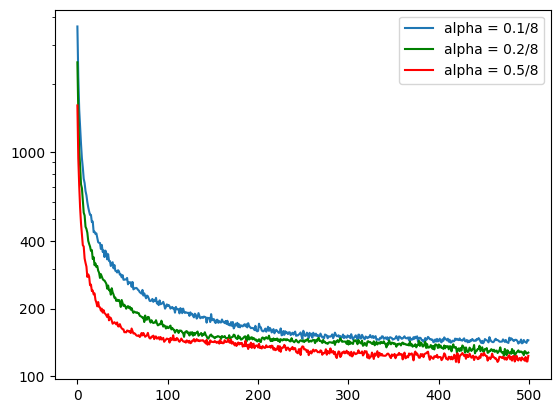

In [ ]:
plt.plot(avg_steps_per_episode_alpha_0_1_8)
plt.plot(avg_steps_per_episode_alpha_0_2_8, color='green')
plt.plot(avg_steps_per_episode_alpha_0_5_8, color='red')
plt.yscale('log')
plt.yticks([100, 200, 400, 1000], ['100', '200', '400', '1000'])
plt.legend(['alpha = 0.1/8', 'alpha = 0.2/8', 'alpha = 0.5/8'])
plt.show()

In [5]:
from autograd import grad
import autograd.numpy as anp

def loss(w, state, action, target):
    x_sa = anp.array(get_action_feature_vector(state, action))
    v_hat = anp.dot(w, x_sa)  # autograd-friendly
    return 0.5 * (target - v_hat) ** 2

grad_loss = grad(loss)

def train_semi_gradient_sarsa(alpha, epsilon, gamma, num_episodes):
    w = np.zeros(NUM_ACTION_FEATURES)
    for episode in range(num_episodes):
        state = get_start_state()
        action = get_next_action(w, state, epsilon)
        steps = 0
        while True:
            next_state, reward = get_next_state_and_reward(state, action)
            steps += 1

            if next_state[0] >= TERMINAL_X:
                target = reward  # semi-gradient: target treated as constant
                g = grad_loss(w, state, action, target)
                w -= alpha * g
                steps_per_episode.append(steps)
                break

            next_action = get_next_action(w, next_state, epsilon)
            target = reward + gamma * get_action_value(next_state, next_action, w)  # constant target
            g = grad_loss(w, state, action, target)
            w -= alpha * g

            state = next_state
            action = next_action
    return w, steps_per_episode


w, steps_per_episode = train_semi_gradient_sarsa(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500)

print(w)
print(steps_per_episode)

episode = generate_episode(w, epsilon=0)
print(len(episode))

[-5.30773578 -8.67651922 -8.29209822 ... -2.91765164 -1.72679317
 -2.0585061 ]
[1487, 1002, 748, 683, 523, 315, 369, 372, 489, 425, 295, 268, 288, 199, 202, 272, 248, 232, 232, 192, 157, 239, 242, 190, 156, 204, 185, 209, 199, 205, 195, 193, 153, 151, 194, 180, 231, 159, 206, 116, 161, 217, 164, 147, 146, 121, 152, 201, 149, 158, 161, 161, 161, 158, 198, 113, 163, 160, 155, 155, 125, 158, 151, 152, 126, 131, 118, 126, 116, 115, 115, 113, 124, 199, 130, 176, 162, 248, 118, 142, 154, 137, 150, 162, 158, 165, 155, 153, 118, 153, 148, 121, 118, 118, 111, 151, 151, 155, 146, 158, 115, 161, 187, 157, 151, 160, 124, 163, 143, 113, 174, 122, 151, 118, 151, 131, 120, 147, 156, 154, 152, 149, 150, 147, 115, 159, 149, 170, 157, 124, 159, 159, 123, 119, 151, 158, 158, 168, 156, 149, 158, 145, 150, 121, 153, 120, 128, 113, 147, 201, 151, 150, 150, 155, 129, 162, 155, 155, 154, 149, 149, 120, 142, 151, 178, 154, 184, 156, 150, 130, 113, 155, 123, 120, 118, 148, 146, 153, 154, 145, 130, 152, 124, 155